# Load data

In [1]:
import sklearn.datasets
import sklearn.model_selection

X, y = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
   X, y, random_state=42
)

# Use Auto-sklearn

In [2]:
import autosklearn.regression
import autosklearn.metrics

# Create and train the estimator 
estimator_askl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=1800,
    seed=42, 
    resampling_strategy='cv',
    resampling_strategy_arguments={'folds': 3},
    n_jobs=2,
    metric=autosklearn.metrics.root_mean_squared_error,
)
# Auto-sklearn ingests the pandas dataframe and detects column types
estimator_askl.fit(X_train, y_train)

AutoSklearnRegressor(metric=root_mean_squared_error, n_jobs=2,
                     per_run_time_limit=360, resampling_strategy='cv',
                     resampling_strategy_arguments={'folds': 3}, seed=42,
                     time_left_for_this_task=1800)

In [3]:
# Score the model
prediction = estimator_askl.predict(X_test)

In [4]:
import sklearn.metrics
performance_askl = sklearn.metrics.mean_squared_error(y_test, prediction, squared=False)
print(f"Auto-Sklearn Classifier performance is {performance_askl}")

Auto-Sklearn Classifier performance is 0.4418807826834934


# Inspecting the output

In [5]:
print(estimator_askl.show_models())

[(0.300000, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'none', 'feature_preprocessor:__choice__': 'polynomial', 'regressor:__choice__': 'gradient_boosting', 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.0022298554040543614, 'feature_preprocessor:polynomial:degree': 2, 'feature_preprocessor:polynomial:include_bias': 'True', 'feature_preprocessor:polynomial:interaction_only': 'False', 'regressor:gradient_boosting:early_stop': 'train', 'regressor:gradient_boosting:l2_regularization': 1.3053128884667706e-10, 'regressor:gradient_boosting:learning_rate': 0.05594167483605857, 'regressor:gradient_boosting:loss': 'l

In [6]:
print(estimator_askl.sprint_statistics())

auto-sklearn results:
  Dataset name: 715fc9db-ef75-11eb-87c1-47901cca4a62
  Metric: root_mean_squared_error
  Best validation score: 0.461728
  Number of target algorithm runs: 63
  Number of successful target algorithm runs: 51
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 6
  Number of target algorithms that exceeded the memory limit: 6



In [7]:
# For compatibility with scikit-learn we implement `cv_results_`
print(estimator_askl.cv_results_)

{'mean_test_score': array([5.18790314e-01, 6.65092897e-01, 2.14748365e+09, 4.61728151e-01,
       4.72634655e-01, 4.62854359e-01, 7.41449333e-01, 2.14748365e+09,
       1.15516100e+00, 7.08922077e-01, 4.76082697e-01, 2.14748365e+09,
       1.14590285e+00, 5.07306910e-01, 2.14748365e+09, 5.17339334e-01,
       4.73343928e-01, 4.99856184e-01, 2.14748365e+09, 6.19939536e-01,
       1.11582001e+00, 5.48428794e-01, 1.06824760e+00, 7.30886711e-01,
       6.51340994e-01, 5.09083029e-01, 5.48123186e-01, 7.16529453e-01,
       6.41706119e-01, 8.00112422e-01, 1.02477070e+00, 1.07573332e+00,
       6.42738362e-01, 7.16529521e-01, 9.81934764e-01, 9.09829604e-01,
       9.88404709e-01, 2.14748365e+09, 2.14748365e+09, 5.90791738e+00,
       7.00054553e-01, 2.14748365e+09, 5.65583087e-01, 1.18835112e+00,
       7.29212312e-01, 2.14748365e+09, 6.57497954e-01, 4.81140600e-01,
       6.70155760e-01, 9.22030025e-01, 2.14748365e+09, 1.15516100e+00,
       7.48066811e-01, 7.16568592e-01, 9.59353622e-01, 9.

# Inspecting the model

## With scikit-learn

### Permutation feature importance

In [8]:
from sklearn.inspection import plot_partial_dependence, permutation_importance
import matplotlib.pyplot as plt

In [ ]:
r = permutation_importance(
    estimator_askl, X_test, y_test,
    n_repeats=10, random_state=0, n_jobs=4,
    scoring='neg_mean_squared_error',
)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sort_idx = r.importances_mean.argsort()
ax.boxplot(r.importances[sort_idx].T, labels=[X_test.columns[i] for i in sort_idx], vert=False)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(20)
fig.tight_layout()

### Partial dependency and individual conditional expectation plots

In [10]:
import matplotlib.pyplot as plt
import sklearn.inspection

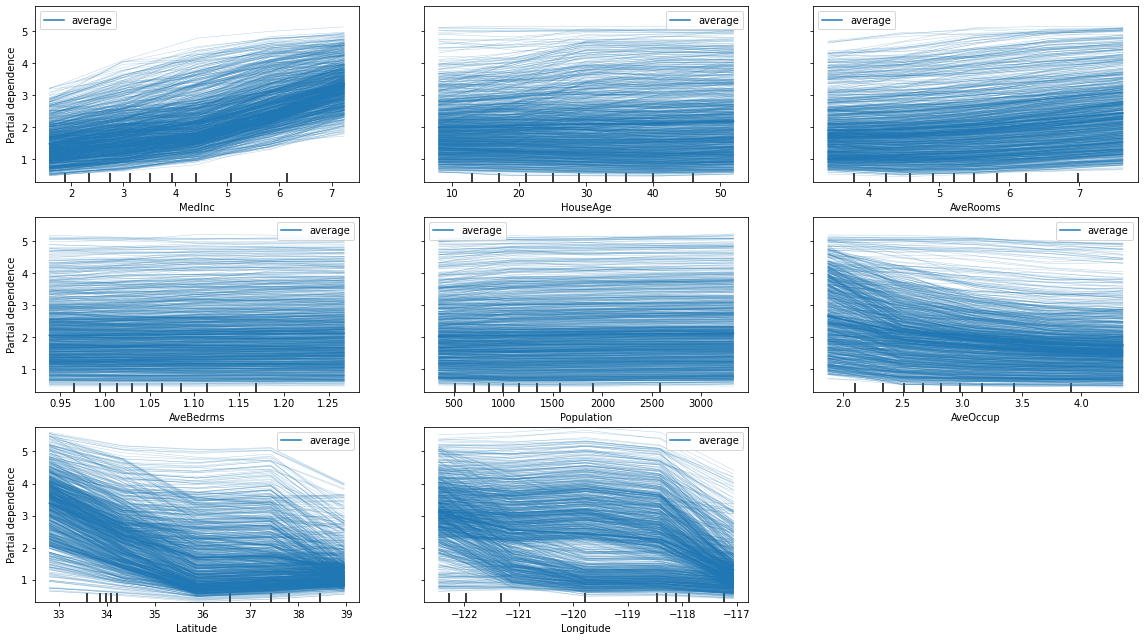

In [11]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
sklearn.inspection.plot_partial_dependence(
    estimator_askl, X_test, features=list(range(X_test.shape[1])),
    grid_resolution=5, kind="both", n_jobs=4, ax=ax,
)
plt.tight_layout()
plt.show()

# With SHAP

In [12]:
import shap
shap.initjs()

In [13]:
# You can increase these values as much as possible given your application
explainer = shap.KernelExplainer(estimator_askl.predict, shap.sample(X_train, 128), link="identity")
shap_values = explainer.shap_values(X_test[:100], nsamples=10)

[WARNING] [2021-07-28 10:01:11,081:shap] Using 128 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.320e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.160e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.983e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.477e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.223e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.974e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.266e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.112e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.486e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.470e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.539e-06, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.925e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=9.714e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.857e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.657e-05, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.926e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.395e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.156e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.459e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.959e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

In [14]:
shap.force_plot(base_value = explainer.expected_value,
                shap_values = shap_values[17],
                features = X.columns.to_list()
                )

In [15]:
print(shap_values.shape)
shap.force_plot(explainer.expected_value, shap_values, X_test, link="identity")

(100, 8)


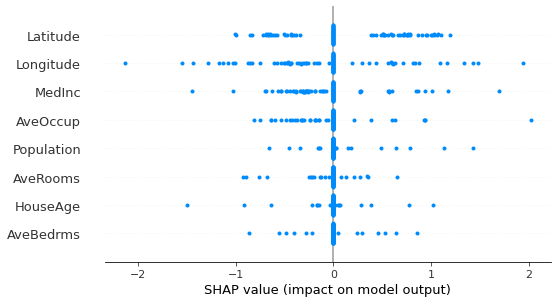

In [16]:
shap.summary_plot(
    shap_values=shap_values, 
    features=X_test.columns.to_list(), 
)